# Automating the evaluation for active learning

Collect the Ground truth specification

In [1]:
from DemoScript import *
from puns.utils import Globally, Eventually, Order
import puns.SpecificationFSMTools as fsm
from puns.Progression import *

import matplotlib
import active_params as params
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [20,10]

from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore") 

In [2]:
params.output_path

'Active_Data/Distributions'

In [3]:
matplotlib.rcParams['figure.figsize'] = [20,10]


In [4]:
ground_truth_formula = ['and']
for i in range(5):
    ground_truth_formula.append(Eventually(f'W{i}'))
ground_truth_formula.append(Order('W0','W2'))
ground_truth_formula.append(Order('W0','W4'))
ground_truth_formula.append(Order('W2','W4'))

In [5]:
def plot_probs(MDP, show_cdf = False):
    Probs = MDP.specification_fsm._partial_rewards
    plt.bar(range(len(Probs)), np.sort(Probs)[::-1])
    if show_cdf:
        f = lambda i: reduce( lambda memo, x: memo+x, np.flip(np.sort(Probs),0)[0:i+1], 0)
        plt.plot(range(len(Probs)), list(map(f, range(len(Probs)))))

Now start by importing the specifications

In [6]:
params.nTraj = 2
raw_data = read_raw_data(params.raw_data_path)
compressed_data = compress_data(raw_data)
write_data(params.compressed_data_path, compressed_data)
params.nSamples = 20000
params.nBurn = 500

In [7]:
infer_command = f'webppl batch_bsi.js --require webppl-json --require webppl-fs -- --nSamples {params.nSamples}  --nBurn {params.nBurn} --dataPath \'{params.compressed_data_path}\' --outPath \'{params.output_path}\' --nTraj {params.nTraj}'
returnval = os.system(infer_command)
if returnval: Exception('Inference Failure')
print(infer_command)

webppl batch_bsi.js --require webppl-json --require webppl-fs -- --nSamples 20000  --nBurn 500 --dataPath 'Active_Data/CompressedData' --outPath 'Active_Data/Distributions' --nTraj 2


The entropy of the distribution is: 4.06448122207757


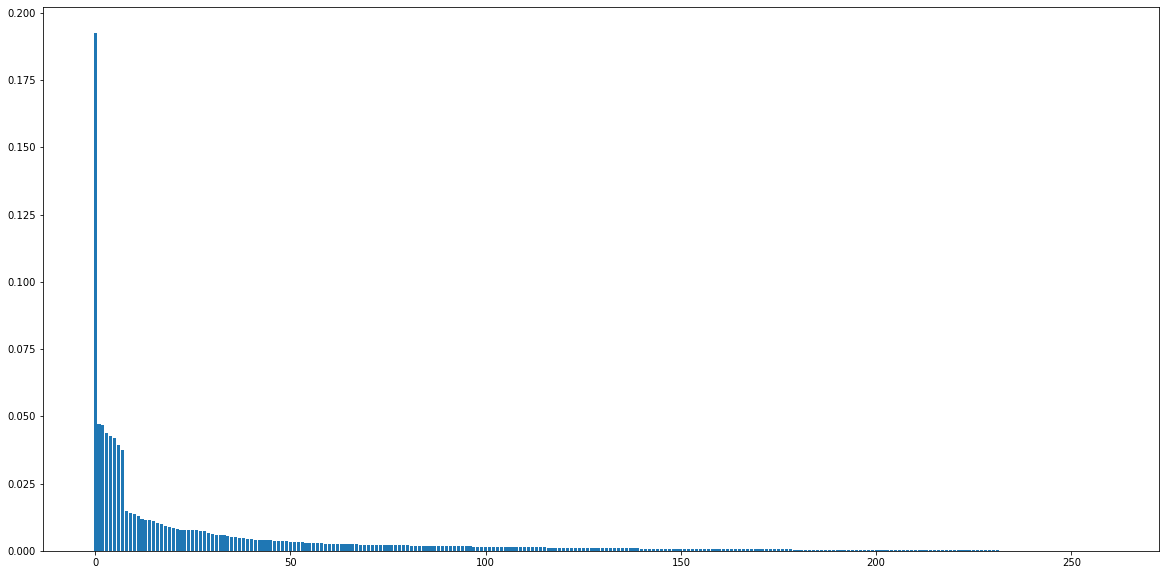

In [8]:
spec_file = os.path.join(params.output_path, 'batch_posterior.json')
MDP = CreateSpecMDP(spec_file, n_threats=0, n_waypoints=5)
print('The entropy of the distribution is:', entropy(MDP.specification_fsm._partial_rewards))
plot_probs(MDP)


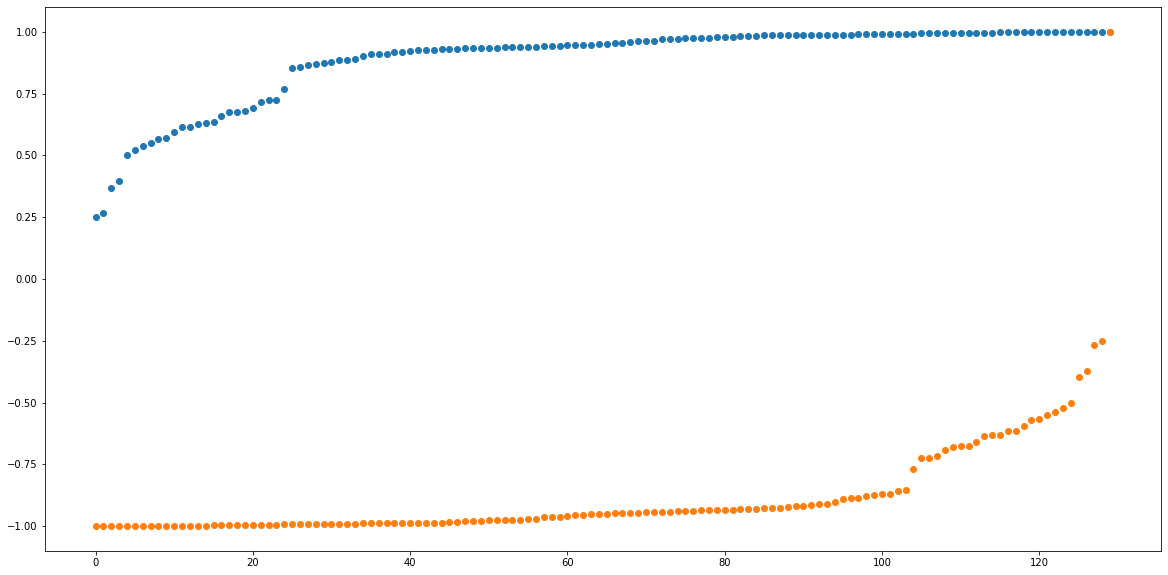

In [9]:
specification_fsm = MDP.specification_fsm
states = list(specification_fsm.states2id.keys())
rewards = [specification_fsm.reward_function(state, force_terminal=True) for state in states]
plt.plot(np.sort(np.abs(rewards)),'o')
plt.plot(np.sort(rewards),'o')

## Queries

Generating Query demo 1
Training episode 4999         
 Plotting query trajectory


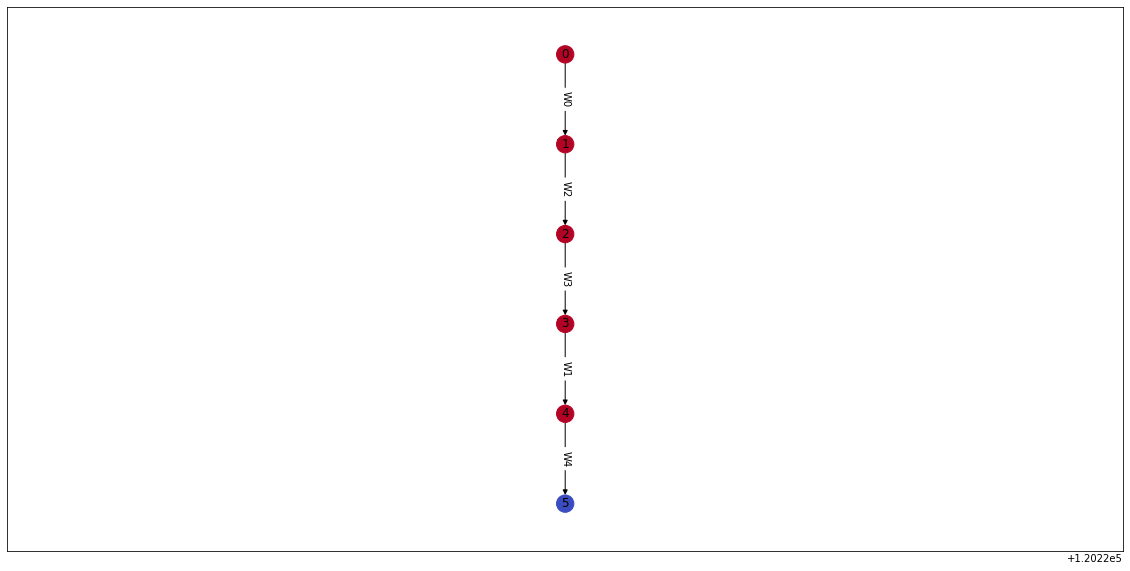

Seeking query label
Assigned label:  True
Writing file: query_1.json
Updating posterior in response to query
Recompiling MDP
The entropy of the distribution after 1 queries is:  3.0664594860145127


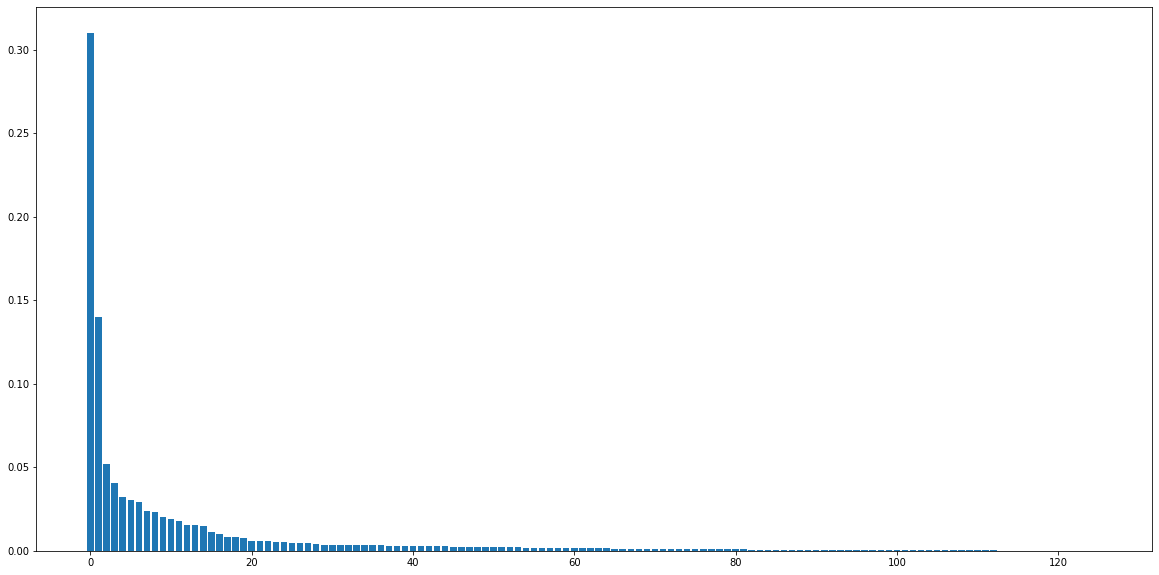

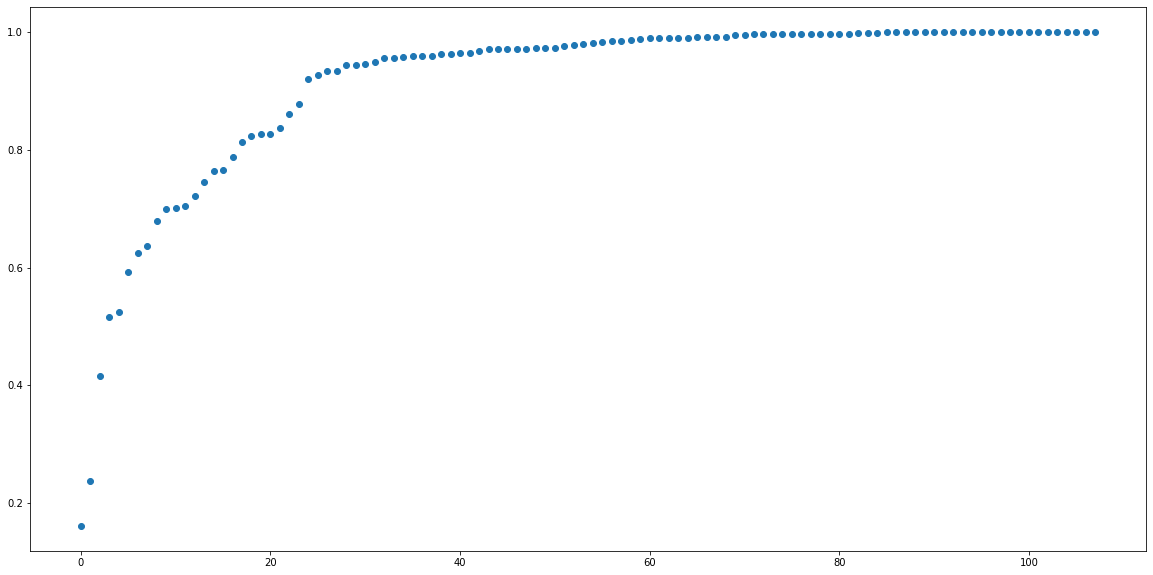

Generating Query demo 2
Training episode 4999         
 Plotting query trajectory


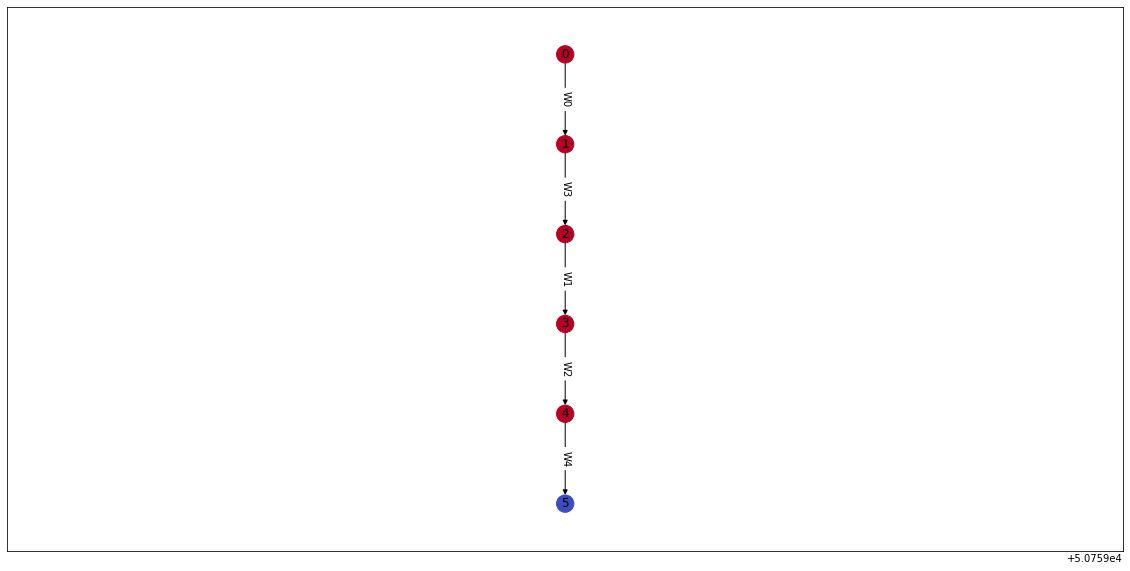

Seeking query label
Assigned label:  True
Writing file: query_2.json
Updating posterior in response to query
Recompiling MDP
The entropy of the distribution after 2 queries is:  1.553940988265344


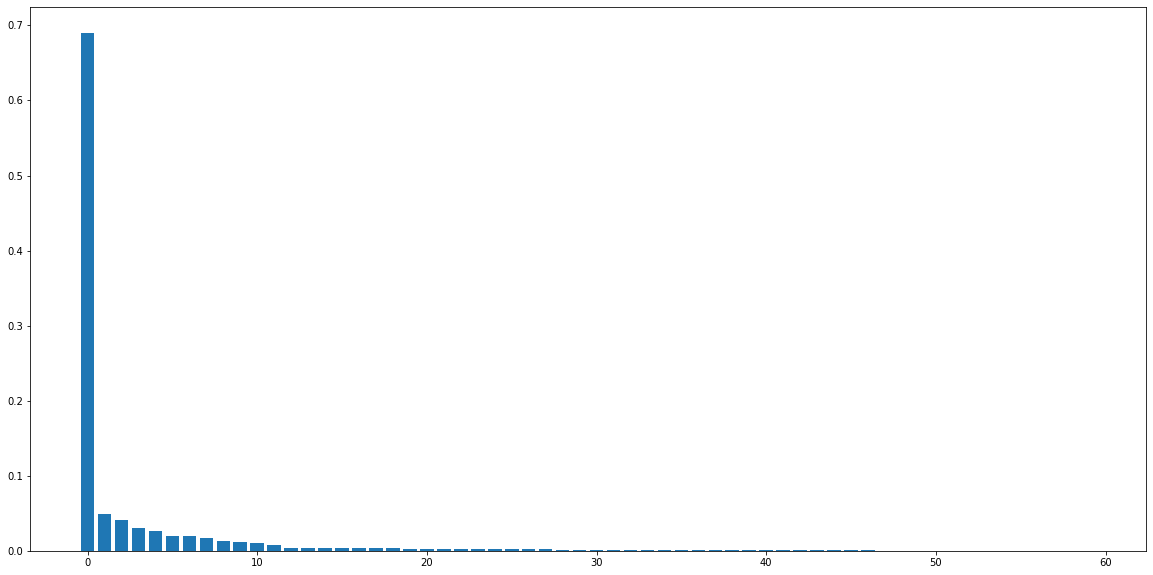

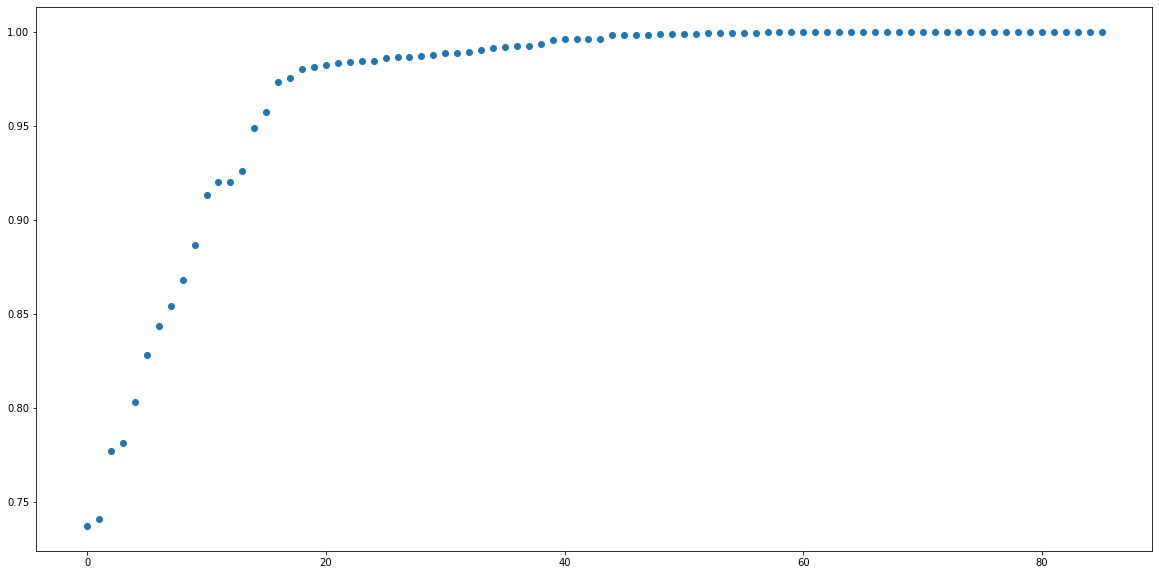

Generating Query demo 3


Training episode 41         

Training episode 3004         

In [ ]:
nQuery = 5
query = []
UpdatedMDP = []
UpdatedMDP.append(MDP)
showPlots = True

for i in range (nQuery):
    
    print(f'Generating Query demo {i+1}')
    query.append(create_active_query(UpdatedMDP[-1], verbose=True, non_terminal=True))
    
    print('\n Plotting query trajectory')
    plt.figure()
    _ = query[-1]['agent'].visualize_exploration()
    plt.show()
    
    print('Seeking query label')
    signal = create_signal(query[-1]['trace'])
    label = Progress(ground_truth_formula, signal)[0]
    print('Assigned label: ', label)
    new_traj = create_query_demo(query[-1]['trace'])
    write_demo_query_data(new_traj, label, params.compressed_data_path, query_number=i+1)
    
    print('Updating posterior in response to query')
    infer_command = f'webppl active_bsi.js --require webppl-json --require webppl-fs -- --nSamples {params.nSamples}  --nBurn {params.nBurn} --dataPath \'{params.compressed_data_path}\' --outPath \'{params.output_path}\' --nQuery {i+1}'
    returnval = os.system(infer_command)
    if returnval:
        Exception('Inference Error')
    
    print('Recompiling MDP')
    spec_file = os.path.join(params.output_path, 'batch_posterior.json')
    UpdatedMDP.append(CreateSpecMDP(spec_file, n_threats=0, n_waypoints=5))
    print(f'The entropy of the distribution after {i+1} queries is: ', entropy(UpdatedMDP[-1].specification_fsm._partial_rewards))
    if showPlots:
        plt.figure()
        plot_probs(UpdatedMDP[-1])
        plt.show()
        
        specification_fsm = UpdatedMDP[-1].specification_fsm
        states = list(specification_fsm.states2id.keys())
        rewards = [specification_fsm.reward_function(state, force_terminal=True) for state in states]
        plt.figure()
        plt.plot(np.sort(np.abs(rewards)),'o')
        plt.show()
        
    

In [24]:
UpdatedMDP[-1].specification_fsm._formulas[3]

['and',
 ['F', ['W1']],
 ['F', ['W3']],
 ['F', ['W4']],
 ['U', ['not', ['W4']], ['W2']],
 ['U', ['not', ['W2']], ['W0']],
 ['U', ['not', ['W4']], ['W0']]]